
# Leveraging Machine Learning for Earthquake Detection 

Overview integrating Seisbench in an earthquake detection workflow 

**Author:** Marc Garcia, University of Texas - El Paso, magarcia58@miners.utep.edu

In [ ]:
!pip install seisbench
!pip install git+https://github.com/AI4EPS/GaMMA.git

# Select Region of Interest(Cascadia)

In [1]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Define the client and geographic bounds of the Cascadia Subduction Zone
client = Client("IRIS")
min_latitude = 40.0
max_latitude = 50.0
min_longitude = -125.0
max_longitude = -120.0

# Fetch station metadata within the defined region for the PNSN network UW, with desired channels
inventory = client.get_stations(network="UW", minlatitude=min_latitude, maxlatitude=max_latitude,
                                minlongitude=min_longitude, maxlongitude=max_longitude,
                                channel="HH*", level="response")  # Fetch response-level metadata

# Define the function to process each station and channel
def process_station(network, station):
    station_list = []
    for channel in station:
        if channel.code[:2] == 'HH':  # Filter for desired channels
            # Check if the channel is active in 2024
            if channel.start_date <= UTCDateTime('2024-12-31') and (channel.end_date is None or channel.end_date >= UTCDateTime('2024-01-01')):
                station_info = {
                    'id': f"{network.code}.{station.code}.",
                    'Network': network.code,
                    'Station': station.code,
                    'Latitude': station.latitude,
                    'Longitude': station.longitude,
                    'Elevation': station.elevation,
                    'Sample Rate': channel.sample_rate
                }
                station_list.append(station_info)
    return station_list

# Use ThreadPoolExecutor to process stations in parallel
station_list = []
with ThreadPoolExecutor() as executor:
    futures = []
    for network in inventory:
        for station in network:
            futures.append(executor.submit(process_station, network, station))
    
    for future in futures:
        station_list.extend(future.result())

# Create DataFrame
station_df = pd.DataFrame(station_list)

# Remove duplicate stations
station_df = station_df.drop_duplicates(subset=['id'])

# Randomly select 50 stations (for testing purposes, comment out if you want full station list)
if len(station_df) > 50:
    station_df = station_df.sample(n=50)

# Display the DataFrame
print(station_df)


            id Network Station   Latitude   Longitude  Elevation  Sample Rate
81    UW.DONK.      UW    DONK  48.423840 -122.156730      892.8        100.0
294   UW.RPW2.      UW    RPW2  48.444880 -121.526540      694.0        100.0
3    UW.ANGUS.      UW   ANGUS  47.100840 -123.492770       89.7        100.0
171  UW.KTSAP.      UW   KTSAP  47.518400 -122.938740      166.9        100.0
315  UW.SKOKO.      UW   SKOKO  47.409080 -123.366500      949.6        100.0
300  UW.SAXON.      UW   SAXON  48.683288 -122.160842      110.8        100.0
213    UW.MEW.      UW     MEW  47.201840 -122.647300      100.5        100.0
87    UW.DOSE.      UW    DOSE  47.717200 -122.971800       53.3        100.0
303  UW.SEAS2.      UW   SEAS2  46.035647 -123.895700       59.3        100.0
93   UW.EAGLE.      UW   EAGLE  47.257720 -122.998500       58.3        100.0
381   UW.WPEQ.      UW    WPEQ  46.613279 -121.404485     1807.0        100.0
318   UW.SLDQ.      UW    SLDQ  48.062240 -124.140920      297.0

# Map View Of Stations

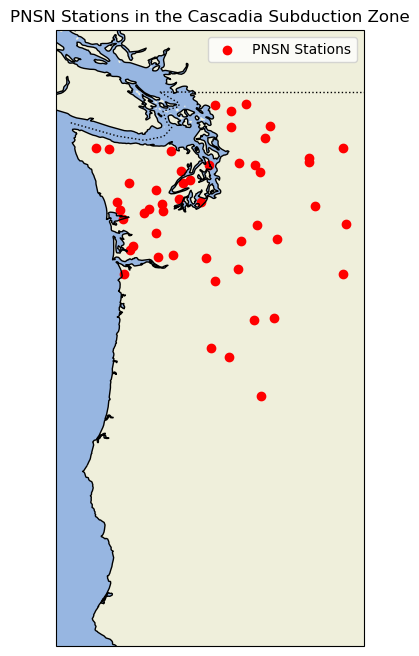

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract station coordinates for the filtered stations
stations = station_df[['Latitude', 'Longitude']].values.tolist()

# Create a plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map bounds
ax.set_extent([min_longitude, max_longitude, min_latitude, max_latitude], crs=ccrs.PlateCarree())

# Plot the stations
if stations:
    lats, lons = zip(*stations)
    ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree(), label='PNSN Stations')

# Add labels and title
ax.set_title('PNSN Stations in the Cascadia Subduction Zone')
ax.legend()

# Show the plot
plt.show()

# Phase Picking with PhaseNet (Seisbench) 

In [5]:
from obspy import UTCDateTime, Stream
import pandas as pd
from collections import Counter
import seisbench.models as sbm
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

picker = sbm.PhaseNet.from_pretrained("original")

# Initialize a single catalog for picks
pick_list = []

# Define start and end times for the period of interest
start_time = UTCDateTime("2024-01-01T00:00:00")
end_time = UTCDateTime("2024-01-02T00:00:00")
window_time = 7200  # 1 hour windows for fetching data

# Function to fetch waveform data for a given station
def fetch_waveform_data(station, current_time, window_time):
    try:
        stream = client.get_waveforms(
            network=station['Network'],
            station=station['Station'],
            location="*",
            channel="HH?",
            starttime=current_time,
            endtime=current_time + window_time
        )
        return stream
    except Exception:
        return Stream()

# Loop through each time window
current_time = start_time

while current_time < end_time:
    combined_stream = Stream()
    
    # Measure the time taken to download data
    start_download_time = time.time()
    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(fetch_waveform_data, station, current_time, window_time) for station in station_list]
        for future in as_completed(futures):
            combined_stream += future.result()
    end_download_time = time.time()
    
    # Classify the combined stream using the PhaseNet picker if it is not empty
    if combined_stream:
        try:
            start_processing_time = time.time()
            picks = picker.classify(
                combined_stream, 
                batch_size=256, 
                P_threshold=0.075, 
                S_threshold=0.1
            ).picks
            end_processing_time = time.time()
            
            # Append picks to the catalog
            pick_list.extend([{
                "id": p.trace_id,
                "timestamp": p.peak_time.datetime,
                "prob": p.peak_value,
                "type": p.phase.lower()
            } for p in picks])
            
            # Print the count of P and S picks and the processing time
            pick_count = Counter(p.phase for p in picks)
            download_time = end_download_time - start_download_time
            processing_time = end_processing_time - start_processing_time
            print(f"Time window starting at {current_time}: {pick_count} (Download time: {download_time:.2f} seconds, Processing time: {processing_time:.2f} seconds)")
        
        except Exception as e:
            print(f"Error processing combined stream at {current_time}: {e}")
    
    # Move to the next time window
    current_time += window_time

# Convert the pick catalog to a DataFrame for further analysis or export
pick_df = pd.DataFrame(pick_list)

# Print the total number of picks
print(f"Total number of picks: {len(pick_df)}")

Time window starting at 2024-01-01T00:00:00.000000Z: Counter({'P': 1743, 'S': 993}) (Download time: 80.18 seconds, Processing time: 30.99 seconds)
Time window starting at 2024-01-01T02:00:00.000000Z: Counter({'P': 1394, 'S': 739}) (Download time: 106.71 seconds, Processing time: 24.69 seconds)
Time window starting at 2024-01-01T04:00:00.000000Z: Counter({'P': 1423, 'S': 789}) (Download time: 139.46 seconds, Processing time: 24.68 seconds)
Time window starting at 2024-01-01T06:00:00.000000Z: Counter({'P': 1236, 'S': 525}) (Download time: 178.85 seconds, Processing time: 24.96 seconds)
Time window starting at 2024-01-01T08:00:00.000000Z: Counter({'P': 937, 'S': 280}) (Download time: 98.73 seconds, Processing time: 24.43 seconds)
Time window starting at 2024-01-01T10:00:00.000000Z: Counter({'P': 904, 'S': 536}) (Download time: 126.33 seconds, Processing time: 24.27 seconds)
Time window starting at 2024-01-01T12:00:00.000000Z: Counter({'P': 1071, 'S': 609}) (Download time: 120.45 seconds, 

In [ ]:
pick_df
station_df

# Phase Association with GaMMA

## Configurations

In [12]:
from pyproj import CRS, Transformer

# Projections
wgs84 = CRS.from_epsg(4326)
local_crs = CRS.from_epsg(2992)  # NAD83(HARN) / Oregon North (ft)
transformer = Transformer.from_crs(wgs84, local_crs)

# Gamma
config = {}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
config["x(km)"] = (0, 2000)
config["y(km)"] = (0, 3000)
config["z(km)"] = (0, 150)
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}  
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 60  # seconds
config["dbscan_min_samples"] = 3

# Filtering
config["min_picks_per_eq"] = 3
config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

station_df["x(km)"] = station_df.apply(lambda x: transformer.transform(x["Latitude"], x["Longitude"])[0] / 1e3, axis=1)
station_df["y(km)"] = station_df.apply(lambda x: transformer.transform(x["Latitude"], x["Longitude"])[1] / 1e3, axis=1)
station_df["z(km)"] = station_df["Elevation"] / 1e3

northing = {station: y for station, y in zip(station_df["id"], station_df["y(km)"])}
station_dict = {station: (x, y) for station, x, y in zip(station_df["id"], station_df["x(km)"], station_df["y(km)"])}

## Association with GaMMA

In [16]:
from gamma.utils import association

catalogs, assignments = association(pick_df, station_df, config, method=config["method"])

catalog = pd.DataFrame(catalogs)
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gamma"])

Associating 244 clusters with 15 CPUs
........................................................................................................
Associated 100 events
.................................................
Associated 200 events
............................................................
Associated 300 events
...............................
Associated 400 events


In [17]:
catalog

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,num_picks,num_p_picks,num_s_picks,event_index,x(km),y(km),z(km)
0,2024-01-01T03:39:31.826,999,1.399396e-07,0,0,2.853599,3,2,1,0,1024.219056,2277.375381,136.256429
1,2024-01-01T18:03:21.463,999,8.083489e-01,0,0,4.000000,3,2,1,11,1012.607641,1847.307328,2.934856
2,2024-01-01T18:03:39.974,999,2.247239e-04,0,0,2.948706,3,2,1,12,1060.259856,1799.165152,70.881479
3,2024-01-01T18:03:47.892,999,5.662670e-01,0,0,2.806981,4,2,2,13,1147.837096,1828.260054,2.443103
4,2024-01-01T18:04:11.623,999,1.824011e-05,0,0,3.141262,3,1,2,14,976.819550,1789.122928,126.621072
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,2024-01-01T16:24:26.694,999,1.088873e+00,0,0,3.408811,4,3,1,374,1011.411272,2359.166856,0.000000
400,2024-01-01T16:25:00.686,999,3.042721e-01,0,0,4.549527,3,2,1,375,1291.966446,2241.905027,0.000000
401,2024-01-01T16:24:30.928,999,4.629387e-01,0,0,6.634079,5,2,3,376,871.336911,2100.638789,0.000000
402,2024-01-01T23:18:40.434,999,1.177491e+00,0,0,5.000001,3,2,1,344,833.354822,1547.524032,0.364585


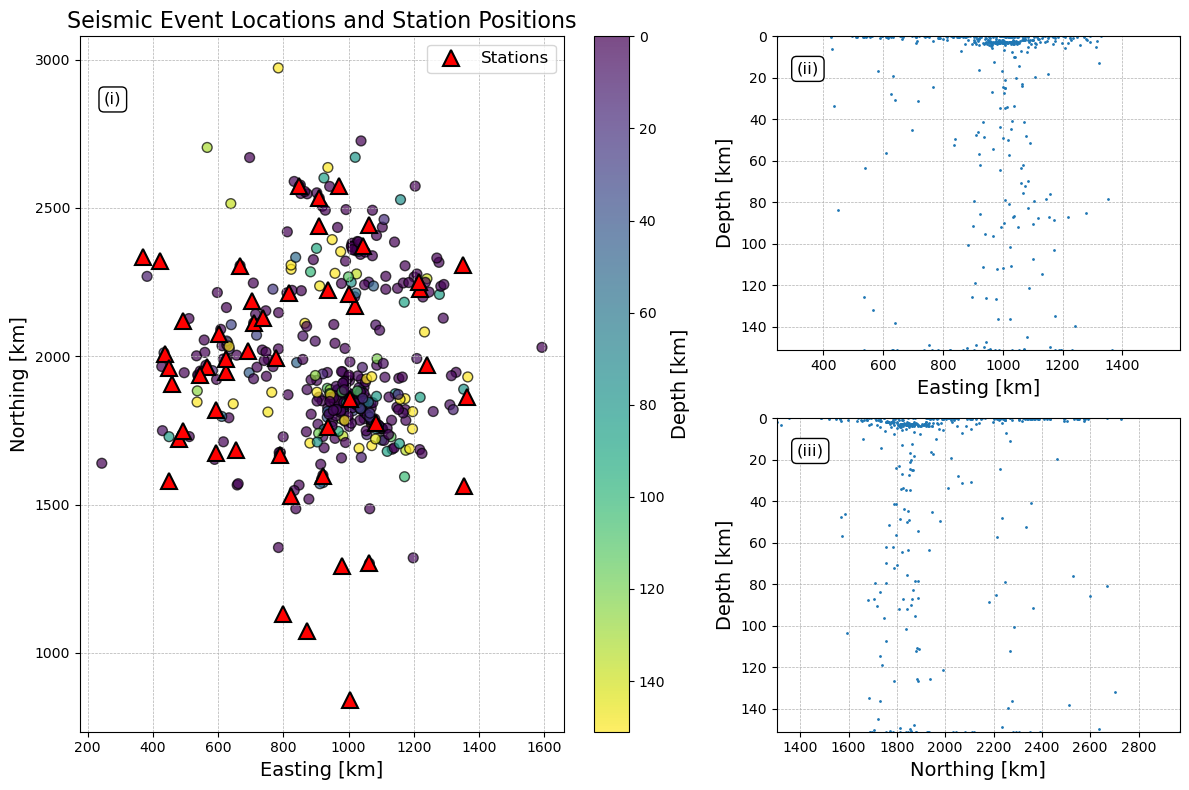

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 8))  # Larger figure for better clarity
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1, 1])

# Main map plot
ax0 = fig.add_subplot(grd[:, 0])
cb = ax0.scatter(catalog["x(km)"], catalog["y(km)"], c=catalog["z(km)"], s=50, cmap="viridis", alpha=0.7, edgecolor='k')
cbar = fig.colorbar(cb, ax=ax0)
cbar.ax.invert_yaxis()
cbar.set_label("Depth [km]", fontsize=14)
ax0.plot(station_df["x(km)"], station_df["y(km)"], "r^", ms=12, mew=1.5, mec="k", label="Stations")
ax0.set_xlabel("Easting [km]", fontsize=14)
ax0.set_ylabel("Northing [km]", fontsize=14)
ax0.set_title("Seismic Event Locations and Station Positions", fontsize=16)
ax0.legend(loc="upper right", fontsize=12)
ax0.grid(True, which='both', linestyle='--', linewidth=0.5)
ax0.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=ax0.transAxes, fontsize="large", fontweight="normal", bbox=box)

# Depth profile along x-axis
ax1 = fig.add_subplot(grd[0, 1])
ax1.plot(catalog["x(km)"], catalog["z(km)"], '.', markersize=2, alpha=1.0, rasterized=True)
ax1.set_xlim([catalog["x(km)"].min(), catalog["x(km)"].max()])
ax1.set_ylim([catalog["z(km)"].max(), catalog["z(km)"].min()])
ax1.set_xlabel("Easting [km]", fontsize=14)
ax1.set_ylabel("Depth [km]", fontsize=14)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=ax1.transAxes, fontsize="large", fontweight="normal", bbox=box)

# Depth profile along y-axis
ax2 = fig.add_subplot(grd[1, 1])
ax2.plot(catalog["y(km)"], catalog["z(km)"], '.', markersize=2, alpha=1.0, rasterized=True)
ax2.set_xlim([catalog["y(km)"].min(), catalog["y(km)"].max()])
ax2.set_ylim([catalog["z(km)"].max(), catalog["z(km)"].min()])
ax2.set_xlabel("Northing [km]", fontsize=14)
ax2.set_ylabel("Depth [km]", fontsize=14)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=ax2.transAxes, fontsize="large", fontweight="normal", bbox=box)

plt.tight_layout()
plt.show()
